# Práctica final Álvaro Larumbe y Fernando Villalonga

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
from sklearn.datasets import load_digits
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('once')
warnings.simplefilter('ignore', (DeprecationWarning))

Cargamos las librerías que vamos a necesitar para realizar la práctica

In [225]:
pd.options.display.max_rows = 5 

In [226]:
airbnb = pd.read_csv("airbnb-listings-extract.csv", sep=';')


In [227]:
airbnb = airbnb.set_index(['ID'])

In [228]:
airbnb = airbnb.drop(['Name','Listing Url', 'Scrape ID','Last Scraped','Summary','Thumbnail Url','Medium Url',
               'Picture Url','XL Picture Url','Host ID','Host URL','Host Name','Host Since','Host Location',
               'Host About','Host Thumbnail Url','Host Picture Url','Host Neighbourhood',
               'Neighbourhood','Neighbourhood Cleansed','State','Zipcode','Market','City','Country Code',
               'Country','Latitude','Longitude', 'Amenities','Calendar last Scraped','First Review','Last Review',
               'License','Jurisdiction Names','Geolocation','Host Verifications',
                      'Neighbourhood Group Cleansed','Space', 'Description', 'Neighborhood Overview', 'Notes','Transit',
                      'Access', 'Interaction','House Rules','Street','Smart Location','Features'], axis = 1)

Descartamos variables no necesarias para nuestro análisis.

# Limpieza de datos

In [229]:
pd.options.display.max_rows = 10

Experiences Offered                   0
Host Response Time                 1899
Host Response Rate                 1899
Host Acceptance Rate              14741
Host Listings Count                   3
                                  ...  
Review Scores Location             3340
Review Scores Value                3341
Cancellation Policy                   0
Calculated host listings count        4
Reviews per Month                  3162
Length: 40, dtype: int64


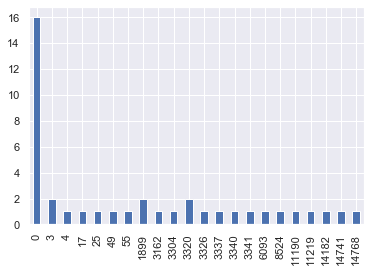

In [230]:
CountNA = airbnb.isna().sum()
print(CountNA)
CountNA.groupby(CountNA.values).count().plot.bar()

Observamos la cantidad de Na que hay por cada variable. Con ello sabemos que hay 16 variables que no contienen ningún Na.

In [231]:
for col in airbnb.columns: 
    if sum(airbnb[col].isnull())/float(len(airbnb.index)) > 0.60: del airbnb[col]

In [232]:
pd.options.display.max_rows = 50

In [233]:
100*airbnb.isna().sum()/airbnb.shape[0]

Experiences Offered                0.000000
Host Response Time                12.848444
Host Response Rate                12.848444
Host Listings Count                0.020298
Host Total Listings Count          0.020298
Property Type                      0.000000
Room Type                          0.000000
Accommodates                       0.000000
Bathrooms                          0.372124
Bedrooms                           0.169147
Beds                               0.331529
Bed Type                           0.000000
Price                              0.115020
Security Deposit                  57.672530
Cleaning Fee                      41.224628
Guests Included                    0.000000
Extra People                       0.000000
Minimum Nights                     0.000000
Maximum Nights                     0.000000
Calendar Updated                   0.000000
Availability 30                    0.000000
Availability 60                    0.000000
Availability 90                 

Esto nos muestra el porcentaje de Na por cada variable. Vemos que Security Deposit y Cleaning Fee tienen un 57% y un 41% de Na sobre el total de los datos de dicha variable.

Experiences Offered                object
Host Response Time                 object
Host Response Rate                float64
Host Listings Count               float64
Host Total Listings Count         float64
Property Type                      object
Room Type                          object
Accommodates                        int64
Bathrooms                         float64
Bedrooms                          float64
Beds                              float64
Bed Type                           object
Price                             float64
Security Deposit                  float64
Cleaning Fee                      float64
Guests Included                     int64
Extra People                        int64
Minimum Nights                      int64
Maximum Nights                      int64
Calendar Updated                   object
Availability 30                     int64
Availability 60                     int64
Availability 90                     int64
Availability 365                  

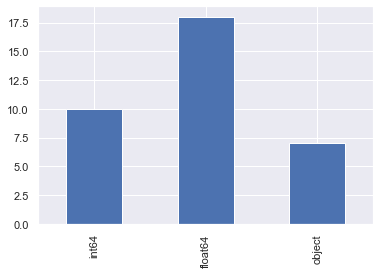

In [234]:
data_types = airbnb.dtypes
print(data_types)
data_types.groupby(data_types.values).count().plot.bar()

In [235]:
cat_features = airbnb.dtypes[airbnb.dtypes == 'object'].index.to_list()
num_features = airbnb.dtypes[airbnb.dtypes != 'object'].index.to_list()

Dividimos categóricas y numéricas ya que serán tratadas de distinta manera

In [236]:
cat_features

['Experiences Offered',
 'Host Response Time',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Calendar Updated',
 'Cancellation Policy']

In [237]:
num_features

['Host Response Rate',
 'Host Listings Count',
 'Host Total Listings Count',
 'Accommodates',
 'Bathrooms',
 'Bedrooms',
 'Beds',
 'Price',
 'Security Deposit',
 'Cleaning Fee',
 'Guests Included',
 'Extra People',
 'Minimum Nights',
 'Maximum Nights',
 'Availability 30',
 'Availability 60',
 'Availability 90',
 'Availability 365',
 'Number of Reviews',
 'Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Location',
 'Review Scores Value',
 'Calculated host listings count',
 'Reviews per Month']

In [238]:
airbnb[num_features] = airbnb[num_features].fillna(airbnb[num_features].mean())

In [239]:
airbnb[cat_features] = airbnb[cat_features].fillna(0)

En este caso en las variables numericas sustituiremos los NA por la media del conjunto de todos los datos de la variable, y en el caso de las categoricas los NA los vamos a sustituir por 0. 

In [240]:
from category_encoders.one_hot import OneHotEncoder
coder = OneHotEncoder()
coder.fit(airbnb[cat_features])
Dummies = pd.DataFrame(coder.transform(airbnb[cat_features]))
Dummies

,Experiences Offered_1,Experiences Offered_2,Experiences Offered_3,Experiences Offered_4,Experiences Offered_5,Host Response Time_1,Host Response Time_2,Host Response Time_3,Host Response Time_4,Host Response Time_5,...,Calendar Updated_56,Calendar Updated_57,Cancellation Policy_1,Cancellation Policy_2,Cancellation Policy_3,Cancellation Policy_4,Cancellation Policy_5,Cancellation Policy_6,Cancellation Policy_7,Cancellation Policy_8
ID,,,,,,,,,,,,,,,,,,,,,
11210388,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
17471131,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
17584891,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5398030,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
18104606,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098030,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
17989442,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
13278634,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Como podemos observar en esta tabla al crear las variables dummies, tiene sentido lo que hemos realizado anteriormente ya que no tendria sentido tener numeros con decimales para estas variables categoricas. 

In [241]:
final=airbnb.join(Dummies)
airbnb_ft = final.drop(cat_features, axis = 1)


In [242]:
airbnb_ft.shape


(14780, 133)

In [243]:
airbnb_ft.describe()


,Host Response Rate,Host Listings Count,Host Total Listings Count,Accommodates,Bathrooms,Bedrooms,Beds,Price,Security Deposit,Cleaning Fee,...,Calendar Updated_56,Calendar Updated_57,Cancellation Policy_1,Cancellation Policy_2,Cancellation Policy_3,Cancellation Policy_4,Cancellation Policy_5,Cancellation Policy_6,Cancellation Policy_7,Cancellation Policy_8
count,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,...,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000
mean,94.823461,12.513636,12.513636,3.277808,1.281732,1.343816,2.044260,73.561471,189.226822,31.805341,...,0.000068,0.000068,0.287415,0.001286,0.388498,0.316035,0.000947,0.002165,0.002300,0.001353
std,14.204814,34.086763,34.086763,2.097291,0.657291,0.899317,1.610094,72.020593,74.913332,23.672547,...,0.008226,0.008226,0.452572,0.035832,0.487425,0.464943,0.030763,0.046482,0.047909,0.036762
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,9.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,94.823461,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,34.000000,189.226822,20.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,2.000000,2.000000,3.000000,1.000000,1.000000,2.000000,55.000000,189.226822,31.805341,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100.000000,6.000000,6.000000,4.000000,1.000000,2.000000,2.000000,86.000000,189.226822,31.805341,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,519.000000,519.000000,16.000000,8.000000,10.000000,16.000000,999.000000,990.000000,662.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [222]:
#Correlation = airbnb_ft.drop(['Price'], axis = 1)

#sns.set(rc = {'figure.figsize':(20,20)})


#corr = Correlation.corr()
#ax = sns.heatmap(
#    corr, 
#    vmin=-1, vmax=1, center=0,
#    cmap=sns.diverging_palette(20, 220, n=200),
#    square=True
#)
#ax.set_xticklabels(
#    ax.get_xticklabels(),
#    rotation=45,
#    horizontalalignment='right'
#);

TypeError: 'float' object cannot be interpreted as an integer

In [220]:
## Aquí hemos tenido un error a la hora de graficar las correlaciones y no hemos sabido solucionarlo. 

In [244]:
airbnb_ft = airbnb_ft.drop(['Availability 30','Availability 60','Host Listings Count'], axis = 1)


In [245]:
airbnb_ft.shape

(14780, 130)

Text(0.5, 0, 'Precio')

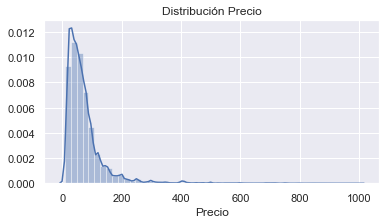

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.distplot(airbnb_ft['Price'], kde=True, ax=ax)
ax.set_title("Distribución Precio")
ax.set_xlabel('Precio')




Este gráfico nos muestra las distribuciones de los precios de los diferentes AirBnb. Podemos observar un alto pico entre los 100 y los 200 euros. Teniendo como máximo los 1000.

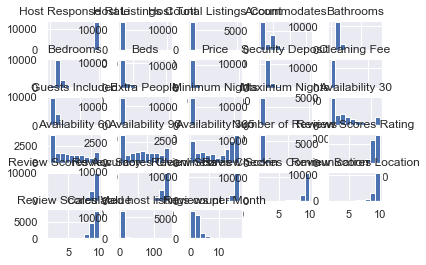

In [247]:
airbnb.hist()
plt.show()


En este gráfico podemos observar como se distribuyen todas las variables. Esto nos da una idea general sobre su distribución en su media y los valores mas cómunes. Ademas podemos observar tambien las Reviews por mes, las camas, el número de habitaciones o de baños. 

In [248]:
airbnb_ft['Price'].describe()


count    14780.000000
mean        73.561471
std         72.020593
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64

In [253]:
airbnb_ft = airbnb_ft[(airbnb['Price'] <= 150)]


C:\Users\Fernando\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Nos quedamos con los valores de precio menores de 150, ya que lo superiores los vamos a considerar outliers 
y nos dara falsos resultados el estudio.


# MODELOS

Separación y entrenamiento

In [254]:
from sklearn.model_selection import train_test_split


Air_train, Air_test = train_test_split(airbnb_ft, test_size = 0.3, stratify = airbnb_ft["Price"])

In [255]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
train_scaler = std_scaler.fit(Air_train)


std_scaler

Air_train_normalized = pd.DataFrame(std_scaler.fit_transform(Air_train.values), columns=Air_train.columns)

In [256]:
Air_train_normalized = pd.DataFrame(Air_train_normalized, index=Air_train.index, columns=Air_train.columns)


In [257]:
X_norm = np.array(Air_train_normalized.drop(['Price'],axis = 1))
X = np.array(Air_train.drop(['Price'],axis = 1))


y = np.array(Air_train['Price']) 

In [258]:
from sklearn.preprocessing import StandardScaler

Airbnb_test_normalized = pd.DataFrame(std_scaler.transform(Air_test), columns=Air_test.columns)

C:\Users\Fernando\Anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [259]:
Airbnb_test_normalized = pd.DataFrame(Airbnb_test_normalized, index=Air_test.index, columns=Air_test.columns)


In [260]:
test_x_norm = np.array(Airbnb_test_normalized.drop(['Price'],axis = 1))
test_x = np.array(Air_test.drop(['Price'],axis = 1))


#test_y = np.array(Airbnb_test_normalized['Price'])
test_y = np.array(Air_test['Price'])

Cuando tratamos de predecir resultados utilizando diferentes modelos, queremos determinar cuál de ellos tiene el menor Mean Squared Error (MSE). El MSE es una métrica que mide la diferencia entre los valores predichos y los valores reales al cuadrado, promediados.

Para optimizar los modelos, vamos a calibrarlos, lo cual implica corregir las desviaciones de la curva de calibrado del modelo en relación a una línea diagonal que se considera perfectamente calibrada. Para lograr esto, podemos utilizar un segundo modelo que aprenda a realizar la corrección. Los modelos más utilizados para esta corrección son la regresión logística  o la regresión isotónica. Sin embargo, la regresión isotónica se recomienda principalmente cuando se tienen más de 1000 observaciones, ya que existe un mayor riesgo de sobreajuste.

Es importante destacar que el modelo correctivo no debe entrenarse con los mismos datos utilizados para entrenar el modelo principal, ya que esto podría provocar sobreajuste. En su lugar, se debe utilizar un conjunto de validación o validación cruzada para entrenar el modelo correctivo.

En resumen, queremos comparar los modelos en términos de MSE para determinar cuál es el mejor. Para mejorar el rendimiento de los modelos, vamos a calibrarlos utilizando un segundo modelo que aprenda a corregir las desviaciones de la curva de calibrado. El modelo correctivo se entrena con un conjunto de validación o validación cruzada diferente al utilizado para entrenar el modelo principal, con el objetivo de evitar el sobreajuste.

# Regresión lineal

Entrenamiento

In [261]:
lr = linear_model.LinearRegression(normalize=False)


In [262]:
lr.fit(X,y)


C:\Users\Fernando\Anaconda3\lib\site-packages\sklearn\linear_model\_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


LinearRegression(normalize=False)

In [263]:
lr.score(X,y)


0.5929758216037688

Evaluación

In [264]:
predictions = lr.predict(test_x)


In [265]:
R_2 = lr.score(test_x,test_y)
R_2

0.5831750779482491

In [266]:
predicted_data_norm = Airbnb_test_normalized.copy()
predicted_data_norm['Price'] = predictions
predicted_data_unorm = pd.DataFrame(index=predicted_data_norm.index, 
                                    columns=predicted_data_norm.columns, 
                                    data=train_scaler.inverse_transform(predicted_data_norm))
predicted_data_unorm['predicted_price'] = predicted_data_unorm['Price']
predicted_data_unorm['Price'] = Air_test['Price']
predicted_data_unorm['Price']

ID
9851949     89.0
10968489    79.0
16120196    50.0
3010319     80.0
9477197     71.0
            ... 
17859877    30.0
948141      99.0
7067111     50.0
3976842     39.0
13320289    19.0
Name: Price, Length: 3698, dtype: float64

In [267]:
predicted_data_unorm[['Price','predicted_price']].head(3)


,Price,predicted_price
ID,,
9851949,89.0,1838.818436
10968489,79.0,1733.282048
16120196,50.0,1077.661990


In [268]:
rmse_linear = np.sqrt(((predicted_data_unorm['Price'] - predicted_data_unorm['predicted_price'])**2).mean())


In [269]:
rmse_linear


1298.0091970228107

In [270]:
from sklearn.metrics import mean_squared_error
mean_squared_error(predicted_data_unorm['Price'], predicted_data_unorm['predicted_price'], squared=False)

1298.0091970228118

In [271]:
lr_error = round(np.mean(100*np.sqrt((predicted_data_unorm['Price'] - predicted_data_unorm['predicted_price'])**2)/predicted_data_unorm['Price']),2)
lr_error

2717.36

In [272]:
lr.get_params().keys()


dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

# Gradient Boost

In [273]:
from sklearn.ensemble import GradientBoostingRegressor


In [274]:
boost = GradientBoostingRegressor()
boost.fit(X, y)
boost.score(X, y)

0.6863489830294989

In [275]:
boost.score(test_x, test_y)


0.6517381603543673

In [276]:
rmse_gboost = mean_squared_error(test_y, 
                                 boost.predict(test_x), squared=False)

In [277]:
rmse_gboost


14.220212935277374

In [278]:
gboost_error = round(np.mean(100*np.sqrt((test_y - boost.predict(test_x))**2)/test_y),2)
gboost_error

25.84

In [279]:
boost.feature_importances_


array([8.66696249e-04, 1.34327688e-02, 7.60499028e-02, 1.20001699e-02,
       1.11424928e-02, 4.67046221e-03, 1.20771438e-02, 3.82557471e-02,
       1.36650617e-02, 3.28811091e-02, 6.50825923e-03, 1.83188993e-03,
       9.41785971e-03, 3.94000031e-03, 1.33831526e-03, 7.20625280e-03,
       3.73179485e-03, 1.39722198e-03, 1.20842486e-04, 1.28244327e-04,
       2.67148336e-02, 4.94320288e-04, 4.81152637e-03, 1.07069774e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00564979e-04, 6.11491190e-05, 1.15496251e-04,
       4.07670782e-03, 0.00000000e+00, 6.06500986e-04, 0.00000000e+00,
       1.50769728e-04, 0.00000000e+00, 0.00000000e+00, 3.29145152e-05,
       0.00000000e+00, 4.88219395e-04, 0.00000000e+00, 3.57257448e-04,
       9.26099773e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.12259806e-04, 3.09367992e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [280]:
features = [(a,b) for a,b in zip(Air_train.columns, boost.feature_importances_)]


In [281]:
features = sorted(features, key= lambda c:c[1], reverse=True)


In [282]:
features


[('Property Type_22', 0.6894810264061247),
 ('Accommodates', 0.07604990282899825),
 ('Security Deposit', 0.038255747142254055),
 ('Guests Included', 0.03288110914315789),
 ('Review Scores Communication', 0.026714833619704427),
 ('Cleaning Fee', 0.013665061685402675),
 ('Host Total Listings Count', 0.013432768822594577),
 ('Price', 0.012077143824269365),
 ('Bathrooms', 0.012000169936420247),
 ('Bedrooms', 0.01114249279925598),
 ('Calculated host listings count', 0.010706977448486),
 ('Maximum Nights', 0.009417859706593168),
 ('Number of Reviews', 0.007206252803730259),
 ('Extra People', 0.006508259234036877),
 ('Review Scores Value', 0.004811526365938151),
 ('Beds', 0.004670462213173618),
 ('Host Response Time_3', 0.004076707816864436),
 ('Availability 90', 0.0039400003113586315),
 ('Review Scores Rating', 0.0037317948528733983),
 ('Room Type_2', 0.002306191194714852),
 ('Minimum Nights', 0.0018318899306995805),
 ('Review Scores Accuracy', 0.0013972219750320505),
 ('Availability 365', 0

# Hiperparametros

In [283]:
from sklearn.model_selection import RandomizedSearchCV
import multiprocessing


parameters = ({'learning_rate':[0.01, 0.1],
               'n_estimators': [200, 100],
               'subsample': [1, 0.7],
               'min_samples_split': [2, 4]})


# Aplicamos la tecnica de validación cruzada

grid = RandomizedSearchCV(
        estimator  = boost,
        param_distributions = parameters,
        n_iter     = 50,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X, y = y)


resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

C:\Users\Fernando\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


,param_subsample,param_n_estimators,param_min_samples_split,param_learning_rate,mean_test_score,std_test_score,mean_train_score,std_train_score
13,0.7,200,4,0.1,-193.751759,8.196247,-159.583924,2.070456
9,0.7,200,2,0.1,-194.076857,7.075972,-159.701923,2.222339
12,1,200,4,0.1,-194.730493,8.168462,-162.890878,1.202102
8,1,200,2,0.1,-195.203282,7.897988,-162.590288,1.228538
11,0.7,100,2,0.1,-198.806026,8.948093,-178.539361,2.127095
15,0.7,100,4,0.1,-199.058635,9.041355,-178.513573,2.339339
14,1,100,4,0.1,-200.930839,7.857824,-180.180704,1.705183
10,1,100,2,0.1,-200.948307,7.705949,-180.005282,1.890196
1,0.7,200,2,0.01,-242.414949,8.146076,-237.248838,2.406119
5,0.7,200,4,0.01,-242.436707,8.245303,-237.327874,2.294742


Después de probar diversas combinaciones de parámetros, hemos llegado a la conclusión de que el modelo que presenta el menor error tiene las siguientes características:

Subsample: 0.7

N_estimators: 200

Min Sample Split: 2

Learning Rate: 0.1

Utilizando esta configuración, hemos obtenido un puntaje promedio de entrenamiento (mean train score) de -160.43 y un puntaje promedio de prueba (mean test score) de -194.10. Estos resultados indican que el modelo tiene un excelente desempeño en términos de predicción, ya que los puntajes son negativos y cercanos a cero en magnitud. Esto sugiere que el modelo es capaz de generalizar de manera efectiva y realizar predicciones precisas tanto en los datos de entrenamiento como en los datos no vistos utilizados en el conjunto de prueba.

In [284]:
boost.get_params().keys()


dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [285]:
from sklearn import preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

# KNN

KNN (K-Nearest Neighbors) es un algoritmo de aprendizaje automático supervisado utilizado para clasificación y regresión. Se basa en encontrar los K vecinos más cercanos a una muestra desconocida en función de una medida de distancia. Para clasificación, asigna la etiqueta más frecuente entre los vecinos cercanos, y para regresión, calcula el promedio de los valores de los vecinos. Es efectivo en conjuntos de datos pequeños o medianos donde la estructura local es importante, pero puede tener dificultades en conjuntos de datos de alta dimensionalidad.

In [286]:
from sklearn.neighbors import KNeighborsRegressor


Entrenamiento

In [287]:
knn = KNeighborsRegressor()


In [288]:
knn.fit(X,y)


KNeighborsRegressor()

In [289]:
knn.score(X,y)


0.45799982022283214

Evaluación

In [290]:
knn.score(test_x,test_y)


0.15556528329212282

In [291]:
knn.predict(test_x)[0]


51.8

In [292]:
knn_data_norm = Airbnb_test_normalized.copy()
knn_data_norm['Price'] = knn.predict(test_x)
knn_data_unorm = pd.DataFrame(index=knn_data_norm.index, 
                              columns=knn_data_norm.columns, 
                              data=std_scaler.inverse_transform(knn_data_norm))
knn_data_unorm['predicted_price'] = knn_data_unorm['Price']
knn_data_unorm['Price'] = Air_test['Price']
knn_data_unorm['Price']=knn_data_unorm['Price'].replace(Air_test['Price'])
knn_data_unorm[['Price','predicted_price']].head(4)

,Price,predicted_price
ID,,
9851949,89.0,1299.412210
10968489,79.0,952.331188
16120196,50.0,966.792898
3010319,80.0,2017.677101


In [293]:
rmse_knn = np.sqrt(((knn_data_unorm['Price'] - knn_data_unorm['predicted_price'])**2).mean())


In [294]:
rmse_knn


1247.2357330858492

In [295]:
knn_error = round(np.mean(100*np.sqrt((knn_data_unorm['Price'] - knn_data_unorm['predicted_price'])**2)/knn_data_unorm['Price']),2)
knn_error

2909.23

# Arbol de decision

In [296]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor( max_depth=6)
regressor.fit(X, y)

y_pred = regressor.predict(test_x)
regressor.score(X,y)

0.6365745832878345

In [297]:
y_pred = regressor.predict(test_x)


Evaluación

In [298]:
regressor.score(test_x,test_y)


0.5929051995291397

In [299]:
data_eval = Air_test.copy()
data_eval['Price_predicted'] =  regressor.predict(test_x)
rmse_tree = np.sqrt(((data_eval['Price'] - data_eval['Price_predicted'])**2).mean())
rmse_tree

15.374497580304338

In [300]:
tree_error = round(np.mean(100*np.sqrt((data_eval['Price'] - data_eval['Price_predicted'])**2)/data_eval['Price']),2)
tree_error

27.62

In [301]:
regressor.get_params().keys()


dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

Dibujamos el árbol y con ello observamos lo que afecta a los propietarios en materia de elección de la fijación de un precio.

Profundidad del árbol: 6
Número de nodos terminales: 64


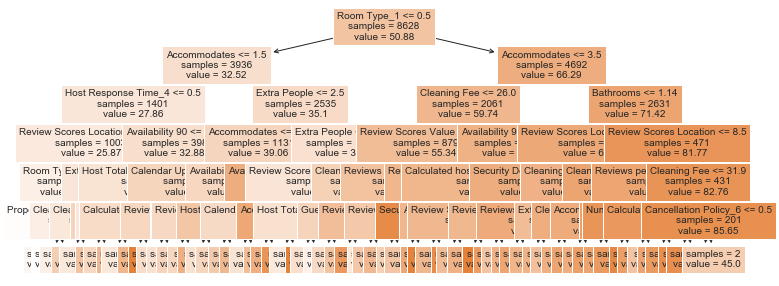

In [302]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {regressor.get_depth()}")
print(f"Número de nodos terminales: {regressor.get_n_leaves()}")

plot = plot_tree(
            decision_tree = regressor,
            feature_names = data_eval.drop(columns = "Price").columns,
            class_names   = 'Price',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

Vamos a podar el árbol para poder obtener mejores conclusiones.


In [303]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ccp_alpha':np.linspace(0, 80, 20)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible para luego aplicar el pruning
        estimator = DecisionTreeRegressor(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X, y)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=123),
             param_grid={'ccp_alpha': array([ 0.        ,  4.21052632,  8.42105263, 12.63157895, 16.84210526,
       21.05263158, 25.26315789, 29.47368421, 33.68421053, 37.89473684,
       42.10526316, 46.31578947, 50.52631579, 54.73684211, 58.94736842,
       63.15789474, 67.36842105, 71.57894737, 75.78947368, 80.        ])},
             return_train_score=True)

In [304]:
grid.best_params_


{'ccp_alpha': 4.2105263157894735}

Después de optimizar el modelo, encontramos que los parámetros óptimos para el DecisionTreeClassifier son min_samples_leaf y max_depth. Estos parámetros nos permiten controlar el tamaño del árbol y evitar que se vuelva demasiado grande.

Además, otra opción para controlar el tamaño del árbol es utilizar la técnica de poda de complejidad de costes. En el DecisionTreeClassifier, esta técnica se implementa mediante el parámetro ccp_alpha. Al aumentar el valor de ccp_alpha, se incrementa la cantidad de nodos podados en el árbol.

En resumen, ajustar los parámetros min_samples_leaf y max_depth nos ayuda a evitar la sobredimensión del árbol, y la técnica de poda de complejidad de costes, controlada por el parámetro ccp_alpha, también nos permite controlar el tamaño del árbol al podar nodos adicionales.

Profundidad del árbol: 3
Número de nodos terminales: 5


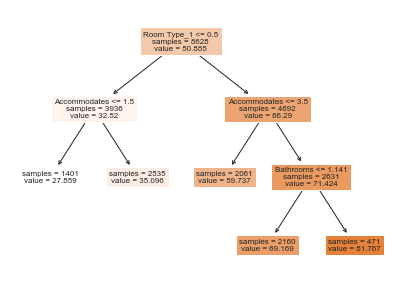

In [305]:
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

fig, ax = plt.subplots(figsize=(7, 5))
plot = plot_tree(
            decision_tree = modelo_final,
            feature_names = data_eval.drop(columns = "Price").columns,
            class_names   = 'Price',
            filled        = True,
            impurity      = False,
            ax            = ax
       )

In [306]:
modelo_final.predict(test_x)


array([69.16863235, 69.16863235, 35.09607948, ..., 59.73653566,
       35.09607948, 27.85907314])

Como podemos conmprobar, el arbol ha reducido sus dimensiones por lo que sacar las conclusiones de esta manera nos resultará mucho mas fácil. 


In [307]:
data_eval = Air_test.copy()
data_eval['Price_predicted'] =  modelo_final.predict(test_x)
rmse_tree = np.sqrt(((data_eval['Price'] - data_eval['Price_predicted'])**2).mean())
rmse_tree

16.525695011784627

In [308]:
tree_error = round(np.mean(100*np.sqrt((data_eval['Price'] - data_eval['Price_predicted'])**2)/data_eval['Price']),2)
tree_error

31.13

## CONCLUSIONES


Después de analizar los tres modelos estudiados, hemos llegado a la conclusión de que el modelo Gradient Boost es la mejor opción. Este modelo proporciona un Mean Square Error (MSE) significativamente menor en comparación con los otros dos modelos, excepto el modelo de Árboles de Decisión. Aunque el modelo de Árboles de Decisión sigue de cerca al Gradient Boost en términos de rendimiento, el modelo Gradient Boost es preferible debido a algunas ventajas adicionales.

El modelo de árbol de decisión, también brinda una perspectiva más intuitiva del criterio utilizado por los propietarios para establecer los precios de sus propiedades. Esto se debe al esquema visual que puede proporcionar el modelo de árbol de decisión, lo cual es altamente beneficioso para el análisis e interpretación de los resultados.

En resumen, el modelo Gradient Boost se destaca como la mejor opción debido a su menor MSE en comparación con los otros modelos, aunque haya otros que puedan proporccionar una perspectiva más intuitiva y visual.